# Import Packages

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import pickle

# Get the Data

First, we start by collecting the accounts and transactions data from the data folder. For that, we define a generic function that allows to load the two csv files into dataframe format. 

In [3]:
DATA_PATH = os.path.join("", "data")

In [4]:
def load_data(data_path=DATA_PATH, csv_name=None):
    """ Load CSV data into a pandas DataFrame."""
    csv_path = os.path.join(data_path, csv_name)
    df = pd.read_csv(csv_path)
    return df

In [5]:
accounts = load_data(DATA_PATH, "accounts.csv")
accounts.head()

,id,balance,update_date
0,0,13.63,2021-07-02
1,1,12.91,2021-07-02
2,2,19.84,2021-07-02
3,3,130.00,2021-07-02
4,4,2806.75,2021-07-02


In [6]:
transactions = load_data(DATA_PATH, "transactions.csv")
transactions.head()

,account_id,date,amount
0,0,2020-10-16,200.0
1,0,2020-10-16,-192.0
2,0,2020-10-16,200.0
3,0,2020-10-16,-24.0
4,0,2020-10-16,-50.0


Let's now merge the two dataframes on the id of the account so we can have compete data. 

In [7]:
# Merge accounts and transactions dataframes
df = pd.merge(accounts, transactions, left_on ='id', right_on = 'account_id')
df.head()

,id,balance,update_date,account_id,date,amount
0,0,13.63,2021-07-02,0,2020-10-16,200.0
1,0,13.63,2021-07-02,0,2020-10-16,-192.0
2,0,13.63,2021-07-02,0,2020-10-16,200.0
3,0,13.63,2021-07-02,0,2020-10-16,-24.0
4,0,13.63,2021-07-02,0,2020-10-16,-50.0


# Data Preprocessing

First, we need to discard accounts having less than 180 days of History. For that, we define a function that takes as input the total history of accounts transactions and returns the list of accounts having more than 180 days of historical data. For each account, we compute the number of days between the update date and the oldest transaction date and store it into a new column. Finally, we keep only accounts having more than 180 days of history. 

In [8]:
def get_180_days_accounts(df: pd.DataFrame):
    """ Cheks for accounts having more than 180 days of history and returns a list of them. """
    # Store the oldest transaction date for each account into a new dataframe
    oldest_df = df.sort_values('date', ascending=False).groupby('id').tail(1)
    # Convert the dates columns into datetime types
    oldest_df['update_date'] = pd.to_datetime(oldest_df['update_date'])
    oldest_df['date'] = pd.to_datetime(oldest_df['date'])
    # Compute the number of days between the update date of the account and the newest date
    oldest_df['nb_days'] = (oldest_df['update_date'] - oldest_df['date']).dt.days
    # Keep only relevant accounts (having more than 180 days of history)
    accounts = oldest_df[oldest_df['nb_days']>=180].id.tolist()
    
    return accounts

In [9]:
# Get the list of accounts having more than 180 days of history
accounts_list = get_180_days_accounts(df)

We filter the dataframe on the returned list of accounts.

In [10]:
df = df[df['id'].isin(accounts_list)]

We sort the dataframe by account id and transactions date and display the data. 

In [11]:
df = df.sort_values(['id', 'date'], ascending = (True, True))

In [12]:
df.head()

,id,balance,update_date,account_id,date,amount
0,0,13.63,2021-07-02,0,2020-10-16,200.0
1,0,13.63,2021-07-02,0,2020-10-16,-192.0
2,0,13.63,2021-07-02,0,2020-10-16,200.0
3,0,13.63,2021-07-02,0,2020-10-16,-24.0
4,0,13.63,2021-07-02,0,2020-10-16,-50.0


# Feature Extraction

In this section, we will build new features that will be provided to our model in order to predict the next month outgoing. 

The first step is to convert the date into a month and a year format. For that, we add two columns where we store the month and year numbers extracted from the date of the transaction. 

In [13]:
def convert_to_month_year(df: pd.DataFrame):
    """ Converts regular date format (Y-M-d) to month-year format (m-Y)."""
    df['month'] = pd.to_datetime(df['date']).dt.month
    df['year'] = pd.to_datetime(df['date']).dt.year
    return df

In [14]:
data = convert_to_month_year(df)
print(data.head())

   id  balance update_date  account_id        date  amount  month  year
0   0    13.63  2021-07-02           0  2020-10-16   200.0     10  2020
1   0    13.63  2021-07-02           0  2020-10-16  -192.0     10  2020
2   0    13.63  2021-07-02           0  2020-10-16   200.0     10  2020
3   0    13.63  2021-07-02           0  2020-10-16   -24.0     10  2020
4   0    13.63  2021-07-02           0  2020-10-16   -50.0     10  2020


In [15]:
data.shape

(466957, 8)

Next, we look for duplicate values and we drop them. 

In [16]:
# remove duplicates 
data=data[data.duplicated()==False]

In [17]:
data.shape

(441880, 8)

At the beginning, we thought about aggregating the total amount of transactions by month. After evaluating the performance of the model based on this feature, we noticed that it wasn't good enough (error was too high), we then opted for separating the flows and computing the ingoing and the outgoing amounts. The next function is hence commented. 

In [18]:
"""
def aggregate_monthly(df: pd.DataFrame):
    # Sums the transactions amounts in the same month and direction (incoming/outgoing) and sorts chronologically.
    df_monthly = df.groupby(['account_id', 'month', 'year'], 
                                            as_index=False)['amount'].sum()
    df_monthly.sort_values(by=['account_id', 'month', 'year'], inplace=True)
    return df_monthly
"""

"\ndef aggregate_monthly(df: pd.DataFrame):\n    # Sums the transactions amounts in the same month and direction (incoming/outgoing) and sorts chronologically.\n    df_monthly = df.groupby(['account_id', 'month', 'year'], \n                                            as_index=False)['amount'].sum()\n    df_monthly.sort_values(by=['account_id', 'month', 'year'], inplace=True)\n    return df_monthly\n"

In [19]:
#data_monthly = aggregate_monthly(data)
#data_monthly = data_monthly.rename(columns={"amount": "average_transactions_amount"})
#print(data_monthly.head())

This function takes the list of negative transactions and and sums them on monthly basis for each account.

In [20]:
def get_monthly_outgoing(df: pd.DataFrame):
    """ Sums the outgoing transactions amounts in the same month and sorts chronologically."""
    ROC = df.loc[df.amount<0]
    ROC = ROC.set_index("date")
    df_outgoing = ROC.groupby(['account_id', 'month', 'year'], 
                                            as_index=False)['amount'].sum()
    df_outgoing.sort_values(by=['account_id', 'month', 'year'], inplace=True)
    df_outgoing = df_outgoing.rename(columns={"amount": "outgoing"})
    return df_outgoing

In [21]:
data_monthly = get_monthly_outgoing(data)
data_monthly.head()

,account_id,month,year,outgoing
0,0,1,2021,-1482.46
1,0,2,2021,-100.00
2,0,3,2021,-396.70
3,0,4,2021,-2183.20
4,0,5,2021,-3322.02


We build a similar function for the ingoing transactions. 

In [22]:
def get_monthly_ingoing(df: pd.DataFrame):
    """ Sums the ingoing transactions amounts in the same month and sorts chronologically."""
    ROC = df.loc[df.amount>=0]
    ROC = ROC.set_index("date")
    df_ingoing = ROC.groupby(['account_id', 'month', 'year'], 
                                            as_index=False)['amount'].sum()
    df_ingoing.sort_values(by=['account_id', 'month', 'year'], inplace=True)
    df_ingoing = df_ingoing.rename(columns={"amount": "ingoing"})
    return df_ingoing

In [23]:
data_ingoing = get_monthly_ingoing(data)

Let's add the feature ingoing to the data_monthly.

In [24]:
keys = ['account_id', 'month', 'year']
data_monthly = pd.merge(data_monthly, data_ingoing, on = keys, how = 'inner')
data_monthly.head()

,account_id,month,year,outgoing,ingoing
0,0,1,2021,-1482.46,2179.0
1,0,2,2021,-100.00,100.0
2,0,3,2021,-396.70,1485.0
3,0,4,2021,-2183.20,2610.5
4,0,5,2021,-3322.02,4892.8


We believe that the number of transactions for each account holds a lot of information into predeciting the account's outgoing. For instance, accounts having higher number of monthly transactions over the years generally present the lower risk of having very hight outgoings. Therefore, we compute it and add it as a feature. 

In [25]:
def compute_average_transactions_per_month(df: pd.DataFrame):
    """ Computes the number of transactions per month for each account. """
    ROC = df.groupby(['account_id', 'month', 'year'],
              as_index=False)['amount'].count()
    ROC = ROC.rename(columns={"amount": "average_transactions_per_month"})
    return ROC

In [26]:
df_transactions_number = compute_average_transactions_per_month(data)
df_transactions_number.head()

,account_id,month,year,average_transactions_per_month
0,0,1,2021,21
1,0,2,2021,9
2,0,3,2021,14
3,0,4,2021,23
4,0,5,2021,46


We add the feature average_transactions_per_month to the data_monthly.

In [27]:
data_monthly = pd.merge(data_monthly, df_transactions_number, on = keys, how = 'inner')
data_monthly.head()

,account_id,month,year,outgoing,ingoing,average_transactions_per_month
0,0,1,2021,-1482.46,2179.0,21
1,0,2,2021,-100.00,100.0,9
2,0,3,2021,-396.70,1485.0,14
3,0,4,2021,-2183.20,2610.5,23
4,0,5,2021,-3322.02,4892.8,46


The function below allows to compute the age of each account up the update date: number of months between the update date and the oldest transation date.

In [28]:
def compute_account_age(df: pd.DataFrame):
    """ Compute the age of the account (Number of months between the update date and the oldest transation date). """
    oldest_df = df.sort_values('date', ascending=False).groupby('account_id').tail(1)
    oldest_df['update_date'] = pd.to_datetime(oldest_df['update_date'])
    oldest_df['date'] = pd.to_datetime(oldest_df['date'])
    oldest_df['age'] = ((oldest_df.update_date - oldest_df.date)/np.timedelta64(1, 'M')).astype(int)
    
    return oldest_df[['account_id', 'age']]
    

In [29]:
data_age = compute_account_age(data)
data_age.head()

,account_id,age
114369,310,5
166487,455,5
161079,442,6
370262,950,6
369453,948,6


We add the feature age to the data_monthly.

In [30]:
data_monthly = pd.merge(data_monthly, data_age, on ='account_id',how = 'inner')
data_monthly.head()

,account_id,month,year,outgoing,ingoing,average_transactions_per_month,age
0,0,1,2021,-1482.46,2179.0,21,8
1,0,2,2021,-100.00,100.0,9,8
2,0,3,2021,-396.70,1485.0,14,8
3,0,4,2021,-2183.20,2610.5,23,8
4,0,5,2021,-3322.02,4892.8,46,8


We think that the initial balance hols an important information about the account.  by combining the transactions and accounts data, we were able to reverse the balance of the account back through time (back to the oldest transaction date for the account). 

In [31]:
# Compute the initial balance for each account
def compute_initial_balance(df: pd.DataFrame, last_balances: pd.DataFrame):
    """ Computes the initial balance of each account given the last balance and the historical transactions. """
    ROC = df.groupby(['account_id'], as_index=False)['amount'].sum()
    df_balance = pd.merge(ROC, last_balances, how='inner', left_on='account_id', right_on='id')
    df_balance['initial_balance'] = df_balance['balance'] - df_balance['amount']
    return df_balance[['account_id', 'initial_balance']]

In [32]:
data_balance = compute_initial_balance(data, accounts)
data_balance.head()

,account_id,initial_balance
0,0,-3835.58
1,1,-1759.97
2,4,-1485.20
3,7,1925.43
4,8,1231.75


We add the feature initial_balance to the data_monthly.

In [33]:
data_monthly = pd.merge(data_monthly, data_balance, on ='account_id',how = 'inner')
data_monthly.head()

,account_id,month,year,outgoing,ingoing,average_transactions_per_month,age,initial_balance
0,0,1,2021,-1482.46,2179.0,21,8,-3835.58
1,0,2,2021,-100.00,100.0,9,8,-3835.58
2,0,3,2021,-396.70,1485.0,14,8,-3835.58
3,0,4,2021,-2183.20,2610.5,23,8,-3835.58
4,0,5,2021,-3322.02,4892.8,46,8,-3835.58


Knowing the current monthly incoming and outgoing, we can shift back the data to compute the previous outgoings/incomings over the 6 past months. 

In [34]:
def Hist(df: pd.DataFrame, n):
    """ Computes the n th previous average amount of transactions for each account. """
    df['outgoing_'+str(n)] = df.groupby('account_id')['outgoing'].shift(n)
    df['ingoing_'+str(n)] = df.groupby('account_id')['ingoing'].shift(n)
    return df

We therefore add 12 features ( 6 previous monthly ingoing abd 6 previous 6 previous outgoings). We denote by outgoing_M, incoming_M the total outgoing, incoming respectively on the M th previous month. 

In [35]:
N = 6
for n in range (1,N+1):
    Hist(data_monthly, n)

In [36]:
data_monthly.head()

,account_id,month,year,outgoing,ingoing,average_transactions_per_month,age,initial_balance,outgoing_1,ingoing_1,outgoing_2,ingoing_2,outgoing_3,ingoing_3,outgoing_4,ingoing_4,outgoing_5,ingoing_5,outgoing_6,ingoing_6
0,0,1,2021,-1482.46,2179.0,21,8,-3835.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,2021,-100.00,100.0,9,8,-3835.58,-1482.46,2179.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,3,2021,-396.70,1485.0,14,8,-3835.58,-100.00,100.0,-1482.46,2179.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,4,2021,-2183.20,2610.5,23,8,-3835.58,-396.70,1485.0,-100.00,100.0,-1482.46,2179.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,5,2021,-3322.02,4892.8,46,8,-3835.58,-2183.20,2610.5,-396.70,1485.0,-100.00,100.0,-1482.46,2179.0,NaN,NaN,NaN,NaN


# Take a Quick look at the Data Structure

In [37]:
data_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11236 entries, 0 to 11235
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   account_id                      11236 non-null  int64  
 1   month                           11236 non-null  int64  
 2   year                            11236 non-null  int64  
 3   outgoing                        11236 non-null  float64
 4   ingoing                         11236 non-null  float64
 5   average_transactions_per_month  11236 non-null  int64  
 6   age                             11236 non-null  int32  
 7   initial_balance                 11236 non-null  float64
 8   outgoing_1                      10384 non-null  float64
 9   ingoing_1                       10384 non-null  float64
 10  outgoing_2                      9546 non-null   float64
 11  ingoing_2                       9546 non-null   float64
 12  outgoing_3                      

In [38]:
data_monthly.describe()

,account_id,month,year,outgoing,ingoing,average_transactions_per_month,age,initial_balance,outgoing_1,ingoing_1,outgoing_2,ingoing_2,outgoing_3,ingoing_3,outgoing_4,ingoing_4,outgoing_5,ingoing_5,outgoing_6,ingoing_6
count,11236.000000,11236.000000,11236.000000,11236.000000,11236.000000,11236.000000,11236.000000,11236.000000,10384.000000,10384.000000,9546.000000,9546.000000,8721.000000,8721.000000,7920.000000,7920.000000,7140.000000,7140.000000,6375.000000,6375.000000
mean,668.203631,6.190993,2020.237451,-5506.632771,5872.192566,38.574404,18.165806,-1020.041703,-5352.331769,5710.374532,-5393.962307,5695.249115,-5367.568719,5686.201269,-5292.965663,5570.686960,-5261.059046,5515.033633,-5228.892667,5514.058712
std,361.239300,3.464771,0.701355,12459.102800,13117.339305,34.190014,8.177504,15001.275139,11106.061735,11763.766576,11231.488473,11721.594767,11347.640232,11873.387466,10622.323987,10518.612663,10164.738941,10298.603669,9916.182374,10371.015410
min,0.000000,1.000000,2018.000000,-532301.650000,0.000000,2.000000,5.000000,-99903.050000,-345792.840000,0.000000,-345792.840000,0.000000,-345792.840000,0.000000,-333806.820000,0.000000,-290729.680000,0.000000,-290729.680000,0.000000
25%,369.000000,3.000000,2020.000000,-6007.117500,1012.870000,12.000000,11.000000,-1161.300000,-5880.470000,1014.750000,-5934.615000,1025.000000,-5870.750000,1041.600000,-5819.690000,1050.000000,-5798.372500,1050.435000,-5780.960000,1072.080000
50%,693.000000,6.000000,2020.000000,-2612.190000,2639.500000,29.000000,17.000000,-158.565000,-2555.880000,2569.410000,-2588.445000,2596.845000,-2580.780000,2581.120000,-2564.550000,2562.370000,-2554.125000,2546.300000,-2561.000000,2565.000000
75%,983.000000,9.000000,2021.000000,-998.795000,6268.692500,55.000000,24.000000,266.310000,-1000.000000,6120.000000,-1017.790000,6110.900000,-1018.880000,6088.220000,-1027.650000,6017.745000,-1029.995000,5983.227500,-1049.270000,5992.100000
max,1253.000000,12.000000,2021.000000,-0.010000,545671.480000,308.000000,41.000000,245309.700000,-0.010000,483133.510000,-0.040000,483133.510000,-0.040000,483133.510000,-0.040000,290882.310000,-0.120000,290882.310000,-0.120000,290882.310000


# Discover and Visualize the Data to Gain Insights

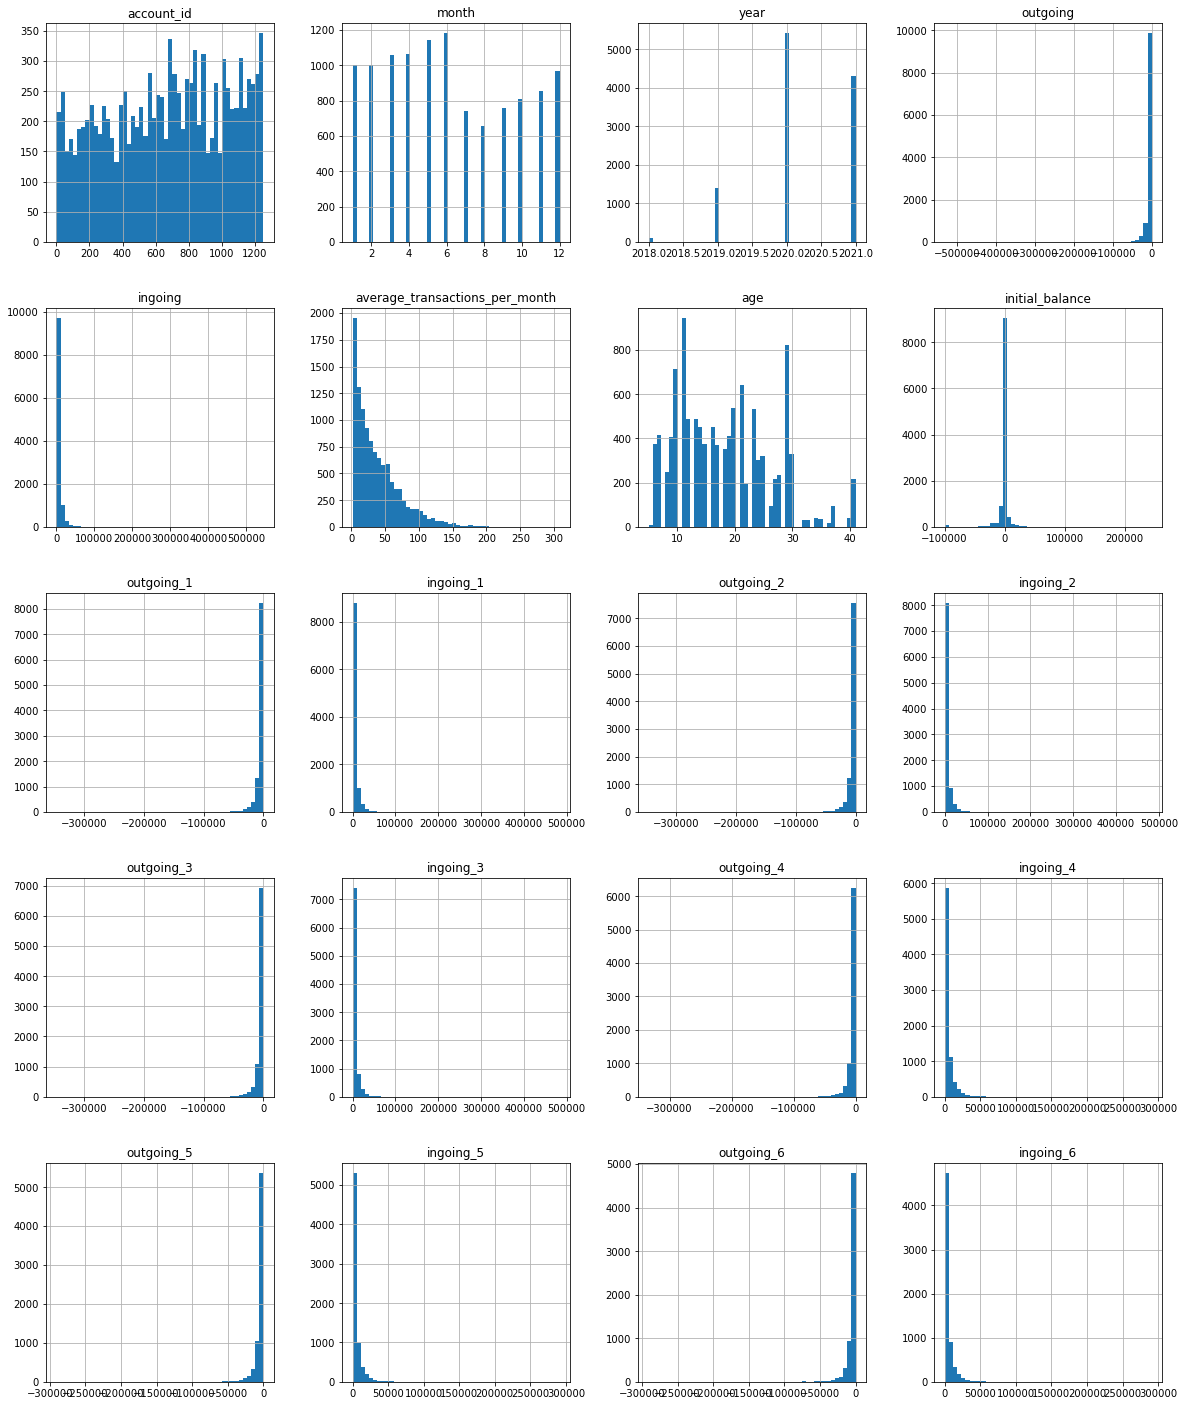

In [39]:
%matplotlib inline 
import matplotlib.pyplot as plt
data_monthly.hist(bins=50, figsize=(20,25))
plt.show()

<AxesSubplot:xlabel='age', ylabel='outgoing'>

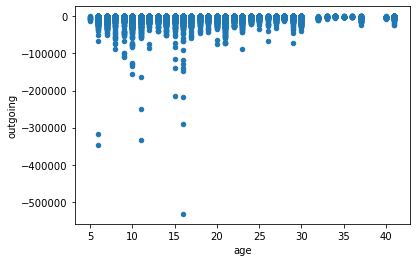

In [40]:
data_monthly.plot(kind="scatter", x="age", y="outgoing")

For instance, the accounts that have just been created (6 months to 9 months) and accounts that have been created for some time (>30 months) present a lower risk of high outgoings.
Their activity is either at its beginning or is mature and stable. 
Contrarily to the accounts having 1 to 3 years of seniority and still trying to run their business present a higher risk of high outgoings. 

<AxesSubplot:xlabel='average_transactions_per_month', ylabel='outgoing'>

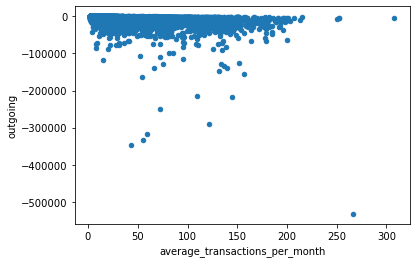

In [41]:
data_monthly.plot(kind="scatter", x="average_transactions_per_month", y="outgoing")

# Create a Train Test Set

In [42]:
data_monthly.shape

(11236, 20)

As we don't have enough data and since we are dealing with Time Series data, I chose to build train and test sets based on the split_month and split year. Meaning, for each account I take the last month for the test set and keep the remaining months(prior to the split month) in the training set. 

In [43]:
def train_test_split(df: pd.DataFrame, df_accounts: pd.DataFrame):
    """ Splits Accounts/Transations Time Series Data into train and test sets. """
    # Sort the dataframe by account id and transactions date
    df = df.sort_values(['account_id', 'year', 'month'], ascending = (True, True, True))
    appended_train_data = []
    appended_test_data = []
    account_dict = df_accounts.set_index('id').T.to_dict('Dict')
    for key in account_dict.keys():
        df_account = df[df['account_id']==key]
        try:
            split_month, split_year = df_account.iloc[-2].month, df_account.iloc[-2].year
            train_set = df_account.loc[~((df.year==split_year) & (df.month>split_month))]
            test_set = df_account.loc[((df.year==split_year) & (df.month>split_month))]
            appended_train_data.append(train_set)
            appended_test_data.append(test_set)
        except:
            pass
    return appended_train_data, appended_test_data


In [44]:
train, test = train_test_split(data_monthly, accounts)

Now, we get our data_train and data_test sets. 

In [45]:
data_train = pd.concat(train)
data_test = pd.concat(test)

In [46]:
data_monthly = data_monthly.drop(["account_id", "ingoing"] ,axis=1)
data_train = data_train.drop(["account_id", "ingoing"] ,axis=1)
data_test = data_test.drop(["account_id", "ingoing"] ,axis=1)

In [47]:
"""
split_year = 2021
split_month = 5

data_monthly = data_monthly.sort_values(['account_id', 'year', 'month'], ascending = (True, True, True))
data_train = data_monthly.loc[~((data_monthly.year==split_year) & (data_monthly.month>split_month))]
data_test = data_monthly.loc[(data_monthly.year==split_year) & (data_monthly.month>split_month)]
"""

"\nsplit_year = 2021\nsplit_month = 5\n\ndata_monthly = data_monthly.sort_values(['account_id', 'year', 'month'], ascending = (True, True, True))\ndata_train = data_monthly.loc[~((data_monthly.year==split_year) & (data_monthly.month>split_month))]\ndata_test = data_monthly.loc[(data_monthly.year==split_year) & (data_monthly.month>split_month)]\n"

# Detecting Outliers

In this part, we handle detecting and removing outliers from the training data. 

In [48]:
data_monthly = data_train

In [49]:
data_monthly.shape

(10409, 18)

<AxesSubplot:>

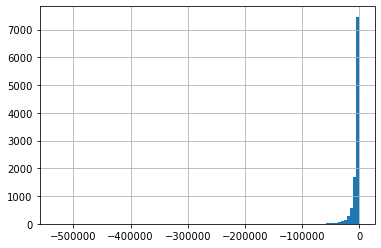

In [50]:
data_monthly.outgoing.hist(bins=100)

When we plot the target variable, we notice that most of the data are centered between -100000 and 0, meaning if we would like to have a better understanding of the data, we need to discard the outliers. 

9367/10409 data points remain.
1042/10409 data points are detected as outliers.


<AxesSubplot:>

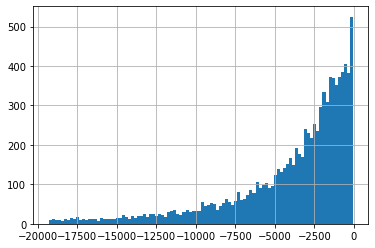

In [51]:
y = data_monthly.outgoing
removed_outliers = y.between(y.quantile(.05), y.quantile(.95))

print(str(y[removed_outliers].size) + "/" + str(y.size) + " data points remain.") 
print(str(y.size - y[removed_outliers].size) + "/" + str(y.size) + " data points are detected as outliers.")

y[removed_outliers].hist(bins=100)

Now, we can have a better understanding of the data by focusing on the more dense intervals. 

In [52]:
data_monthly = data_monthly[y.between(y.quantile(.05), y.quantile(.95))]

In [53]:
#%matplotlib inline 
#data_monthly.hist(bins=50, figsize=(20,25))
#plt.show()

<AxesSubplot:xlabel='average_transactions_per_month', ylabel='outgoing'>

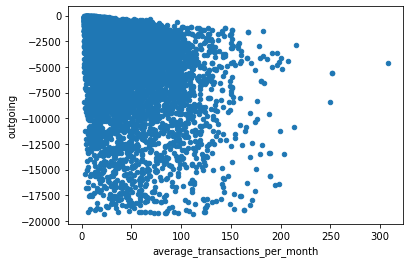

In [54]:
data_monthly.plot(kind="scatter", x="average_transactions_per_month", y="outgoing")

<AxesSubplot:xlabel='age', ylabel='outgoing'>

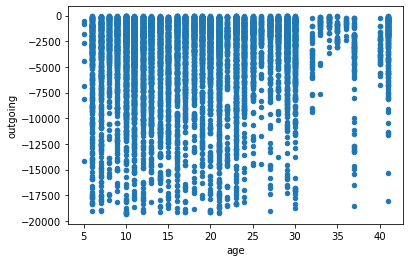

In [55]:
data_monthly.plot(kind="scatter", x="age", y="outgoing")

# Computing correlations between target variable and features

We can start by looking at correlations between the predicted value and the features. 

In [56]:
# Computing the standard correlation coefficient (Pearson)
corr_matrix = data_monthly.corr()
corr_matrix["outgoing"].sort_values(ascending=False)

outgoing                          1.000000
outgoing_2                        0.389788
outgoing_4                        0.368321
outgoing_1                        0.361037
outgoing_6                        0.342030
outgoing_5                        0.292092
outgoing_3                        0.282062
age                               0.139394
month                             0.002783
initial_balance                  -0.008833
year                             -0.147938
ingoing_5                        -0.277236
ingoing_3                        -0.301062
ingoing_6                        -0.349539
ingoing_4                        -0.354441
ingoing_1                        -0.373177
average_transactions_per_month   -0.378829
ingoing_2                        -0.395659
Name: outgoing, dtype: float64

We notice that outgoing variable is highly correlated with the previous outgoings and negatively correlated with the previous ingoings as well since the have a direct impact on the upcoming outgoings. Other variable such as the age of account and the average transactions per month showed a relatively high correlation score.  

In [57]:
"""
import seaborn as sns
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=.12, annot=True,square=True);
"""

'\nimport seaborn as sns\nf, ax = plt.subplots(figsize=(12, 9))\nsns.heatmap(corr_matrix, vmax=.12, annot=True,square=True);\n'

# Prepare the Data for Machine Learning Algorithms

In this part, we process the Variance Inflation Factor test only to drop highly correlated features since we will be using Descion Trees based models, we don't really need to check the multicollinearity hypothesis. 

In [58]:
#import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = SimpleImputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=10.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            #vif = [sm.stats.outliers_influence.variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > 10:
                maxloc = vif.index(max_vif)
                print('Dropping:', X.columns[maxloc], 'with vif=',max_vif)
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X         

In [59]:
transformer = ReduceVIF()

In [60]:
X = data_monthly.drop(["outgoing"] ,axis=1)
y = data_monthly["outgoing"].copy()



In [61]:
predictors= transformer.fit_transform(X, y)

ReduceVIF fit
ReduceVIF transform
Dropping: year with vif= 11.51501295435539


We end up with these features that represent most the data. 

In [62]:
predictors.columns

Index(['month', 'average_transactions_per_month', 'age', 'initial_balance',
       'outgoing_1', 'ingoing_1', 'outgoing_2', 'ingoing_2', 'outgoing_3',
       'ingoing_3', 'outgoing_4', 'ingoing_4', 'outgoing_5', 'ingoing_5',
       'outgoing_6', 'ingoing_6'],
      dtype='object')

# Select and train a model

In [63]:
label="outgoing"
numerical_features=[
    'month',
    'average_transactions_per_month',
    'age',
    'initial_balance',
    'outgoing_1',
    'ingoing_1',
    'outgoing_2',
    'ingoing_2',
    'outgoing_3',
    'ingoing_3',
    'outgoing_4',
    'ingoing_4',
    'outgoing_5',
    'ingoing_5',
    'outgoing_6',
    'ingoing_6'
]

In [64]:
data_monthly.shape

(9367, 18)

In [65]:
X_train = data_monthly[numerical_features]
y_train = data_monthly[label]

X_test = data_test[numerical_features]
y_test = data_test[label]

In [66]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify the configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'n_estimators':2000,
    'objective': 'regression',
    'metric': {'l2', 'l1', 'mape'},
    'num_leaves': 50,
    'learning_rate': 0.05,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

Starting training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's l2: 1.83672e+08	valid_0's mape: 57.9561	valid_0's l1: 4856.23
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 1.8208e+08	valid_0's mape: 56.6572	valid_0's l1: 4777.12
[3]	valid_0's l2: 1.80475e+08	valid_0's mape: 55.5549	valid_0's l1: 4701.8
[4]	valid_0's l2: 1.78954e+08	valid_0's mape: 54.4587	valid_0's l1: 4626.87
[5]	valid_0's l2: 1.77554e+08	valid_0's mape: 53.1057	valid_0's l1: 4552.85
[6]	valid_0's l2: 1.76297e+08	valid_0's mape: 51.9902	valid_0's l1: 4485.88
[7]	valid_0's l2: 1.75153e+08	valid_0's mape: 50.846	valid_0's l1: 4425.31
[8]	valid_0's l2: 1.73934e+08	valid_0's mape: 49.7087	valid_0's l1: 4366.38
[9]	valid_0's l2: 1.72795e+08	valid_0's mape: 48.5052	valid_0's l1: 4307.97
[10]	vali

C:\Users\Recommerce\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\Recommerce\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[66]	valid_0's l2: 1.55802e+08	valid_0's mape: 28.2927	valid_0's l1: 3308.27
[67]	valid_0's l2: 1.55622e+08	valid_0's mape: 28.266	valid_0's l1: 3304.72
[68]	valid_0's l2: 1.55647e+08	valid_0's mape: 28.0794	valid_0's l1: 3302.52
[69]	valid_0's l2: 1.55624e+08	valid_0's mape: 27.9334	valid_0's l1: 3299.08
[70]	valid_0's l2: 1.55533e+08	valid_0's mape: 27.8415	valid_0's l1: 3293.25
[71]	valid_0's l2: 1.55459e+08	valid_0's mape: 27.6714	valid_0's l1: 3289.67
[72]	valid_0's l2: 1.55344e+08	valid_0's mape: 27.5101	valid_0's l1: 3285.59
[73]	valid_0's l2: 1.55303e+08	valid_0's mape: 27.4159	valid_0's l1: 3283.08
[74]	valid_0's l2: 1.5523e+08	valid_0's mape: 27.3224	valid_0's l1: 3280.98
[75]	valid_0's l2: 1.55152e+08	valid_0's mape: 27.2151	valid_0's l1: 3277.05
[76]	valid_0's l2: 1.55029e+08	valid_0's mape: 27.0286	valid_0's l1: 3274.08
[77]	valid_0's l2: 1.54998e+08	valid_0's mape: 26.8696	valid_0's l1: 3270.5
[78]	valid_0's l2: 1.5495e+08	valid_0's mape: 26.853	valid_0's l1: 3269.88
[79]

In [67]:
data_monthly.outgoing.mean()

-3989.102868581195

In [68]:
gbm.eval

<bound method Booster.eval of <lightgbm.basic.Booster object at 0x0000019957102730>>

In [69]:
X_test.iloc[0]

month                                6.00
average_transactions_per_month      60.00
age                                  8.00
initial_balance                  -3835.58
outgoing_1                       -3322.02
ingoing_1                         4892.80
outgoing_2                       -2183.20
ingoing_2                         2610.50
outgoing_3                        -396.70
ingoing_3                         1485.00
outgoing_4                        -100.00
ingoing_4                          100.00
outgoing_5                       -1482.46
ingoing_5                         2179.00
outgoing_6                            NaN
ingoing_6                             NaN
Name: 5, dtype: float64

In [70]:
gbm.predict(X_test.iloc[0])

C:\Users\Recommerce\anaconda3\lib\site-packages\lightgbm\basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


array([-3886.8546961])

In [71]:
import xgboost as xg
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_percentage_error 

In [72]:
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)
  
# Fitting the model
xgb_r.fit(X_train, y_train)
  
# Predict the model
pred = xgb_r.predict(X_test)
  
# RMSE Computation
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE : % f" %(rmse))

  
# MAPE Computation
mape = np.sqrt(mean_absolute_percentage_error(y_test, pred))
print("MAPE : % f" %(mape))

[00:40:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
RMSE :  12654.446455
MAPE :  15.975232


# Create a Pickle and save the gbm model

In [73]:
pickle_out = open("lightgbm.pkl","wb")
pickle.dump(gbm, pickle_out)
pickle_out.close()

In [74]:
"""
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
lin_reg.coef_

from sklearn.metrics import mean_squared_error
outgoing_predictions = lin_reg.predict(X_train)
lin_mse = mean_squared_error(y_train, outgoing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

lin_reg.score(X_train, y_train)


"""

'\nfrom sklearn.linear_model import LinearRegression\n\nlin_reg = LinearRegression()\nlin_reg.fit(X_train, y_train)\nlin_reg.coef_\n\nfrom sklearn.metrics import mean_squared_error\noutgoing_predictions = lin_reg.predict(X_train)\nlin_mse = mean_squared_error(y_train, outgoing_predictions)\nlin_rmse = np.sqrt(lin_mse)\nlin_rmse \n\nlin_reg.score(X_train, y_train)\n\n\n'

In [75]:
# Feature Scaling

In [76]:
# As with all transformations, it is important to fit the scalers to training data only, not the full dataset. 

In [77]:
"""
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#train_set_scaled=scaler.fit_transform(train_set)
#train_set_scaled= pd.DataFrame(train_set_scaled)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
"""

'\nfrom sklearn.preprocessing import MinMaxScaler\nscaler = MinMaxScaler()\n#train_set_scaled=scaler.fit_transform(train_set)\n#train_set_scaled= pd.DataFrame(train_set_scaled)\nX_train_scaled = scaler.fit_transform(X_train)\nX_test_scaled = scaler.fit_transform(X_test)\n'

In [78]:
"""
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=0).fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))


print("test score:", model.score(X_test, y_test))
"""

'\nfrom sklearn.ensemble import GradientBoostingRegressor\nmodel = GradientBoostingRegressor(random_state=0).fit(X_train, y_train)\nprint("train score:", model.score(X_train, y_train))\n\n\nprint("test score:", model.score(X_test, y_test))\n'

In [79]:
"""
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=0).fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))

print("test score:", model.score(X_test, y_test))
"""

'\nfrom sklearn.ensemble import RandomForestRegressor\n\nmodel = RandomForestRegressor(random_state=0).fit(X_train, y_train)\nprint("train score:", model.score(X_train, y_train))\n\nprint("test score:", model.score(X_test, y_test))\n'